In [2]:
!pip install neo4j openai

### Stage 1: Data Sources and Knowledge Graph Construction

Knowledge Graph Construction: Using this data, the graph establishes relationships between users, products, and categories. These nodes and relationships, like "VIEWED", "PURCHASED", and "SIMILAR_TO", are critical in reducing hallucinations by grounding the LLM with real-world connections.

In [7]:
from neo4j import GraphDatabase

# Neo4j instance
uri = "uri link here"  
username = "neo4j"  
password = "password"  
driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to create nodes and relationships
def create_kg(tx):
    # Creating Users
    tx.run("CREATE (u1:User {id: 'user1', name: 'Alice'})")
    tx.run("CREATE (u2:User {id: 'user2', name: 'Bob'})")
    
    # Creating Products
    tx.run("CREATE (p1:Product {id: 'product1', name: 'iPhone 14', price: 999})")
    tx.run("CREATE (p2:Product {id: 'product2', name: 'Samsung Galaxy S22', price: 849})")
    tx.run("CREATE (p3:Product {id: 'product3', name: 'Google Pixel 7', price: 599})")
    
    # Creating Categories
    tx.run("CREATE (c1:Category {id: 'category1', name: 'Smartphones'})")
    tx.run("CREATE (c2:Category {id: 'category2', name: 'Accessories'})")
    
    # Creating Brands
    tx.run("CREATE (b1:Brand {id: 'brand1', name: 'Apple'})")
    tx.run("CREATE (b2:Brand {id: 'brand2', name: 'Samsung'})")
    tx.run("CREATE (b3:Brand {id: 'brand3', name: 'Google'})")

    # Establishing relationships
    # User interactions
    tx.run("MATCH (u1:User {id: 'user1'}), (p1:Product {id: 'product1'}) "
           "CREATE (u1)-[:VIEWED]->(p1)")
    tx.run("MATCH (u2:User {id: 'user2'}), (p2:Product {id: 'product2'}) "
           "CREATE (u2)-[:PURCHASED]->(p2)")
    tx.run("MATCH (u1:User {id: 'user1'}), (p2:Product {id: 'product2'}) "
           "CREATE (u1)-[:LIKED]->(p2)")
    
    # Product relationships
    tx.run("MATCH (p1:Product {id: 'product1'}), (c1:Category {id: 'category1'}) "
           "CREATE (p1)-[:BELONGS_TO]->(c1)")
    tx.run("MATCH (p2:Product {id: 'product2'}), (c1:Category {id: 'category1'}) "
           "CREATE (p2)-[:BELONGS_TO]->(c1)")
    tx.run("MATCH (p3:Product {id: 'product3'}), (c1:Category {id: 'category1'}) "
           "CREATE (p3)-[:BELONGS_TO]->(c1)")
    
    # Brand relationships
    tx.run("MATCH (p1:Product {id: 'product1'}), (b1:Brand {id: 'brand1'}) "
           "CREATE (p1)-[:MANUFACTURED_BY]->(b1)")
    tx.run("MATCH (p2:Product {id: 'product2'}), (b2:Brand {id: 'brand2'}) "
           "CREATE (p2)-[:MANUFACTURED_BY]->(b2)")
    tx.run("MATCH (p3:Product {id: 'product3'}), (b3:Brand {id: 'brand3'}) "
           "CREATE (p3)-[:MANUFACTURED_BY]->(b3)")
    
    # Similarity relationships
    tx.run("MATCH (p1:Product {id: 'product1'}), (p2:Product {id: 'product2'}) "
           "CREATE (p1)-[:SIMILAR_TO]->(p2)")
    tx.run("MATCH (p2:Product {id: 'product2'}), (p3:Product {id: 'product3'}) "
           "CREATE (p2)-[:SIMILAR_TO]->(p3)")

# Querying the knowledge graph
def query_kg(tx):
    result = tx.run("""
        MATCH (u:User)-[r]->(p:Product)
        RETURN u.name AS user, type(r) AS interaction, p.name AS product
    """)
    for record in result:
        print(f"{record['user']} {record['interaction']} {record['product']}")

# Creating and querying the knowledge graph
with driver.session() as session:
    # Create the knowledge graph
    session.write_transaction(create_kg)
    print("Knowledge graph constructed successfully!")
    
    # Query the knowledge graph
    print("User interactions:")
    session.read_transaction(query_kg)

# Close the driver
driver.close()


C:\Users\ramda\AppData\Local\Temp\ipykernel_90156\910745362.py:72: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_kg)


Knowledge graph constructed successfully!
User interactions:
Alice VIEWED iPhone 14
Alice LIKED Samsung Galaxy S22
Bob PURCHASED Samsung Galaxy S22


C:\Users\ramda\AppData\Local\Temp\ipykernel_90156\910745362.py:77: DeprecationWarning: read_transaction has been renamed to execute_read
  session.read_transaction(query_kg)


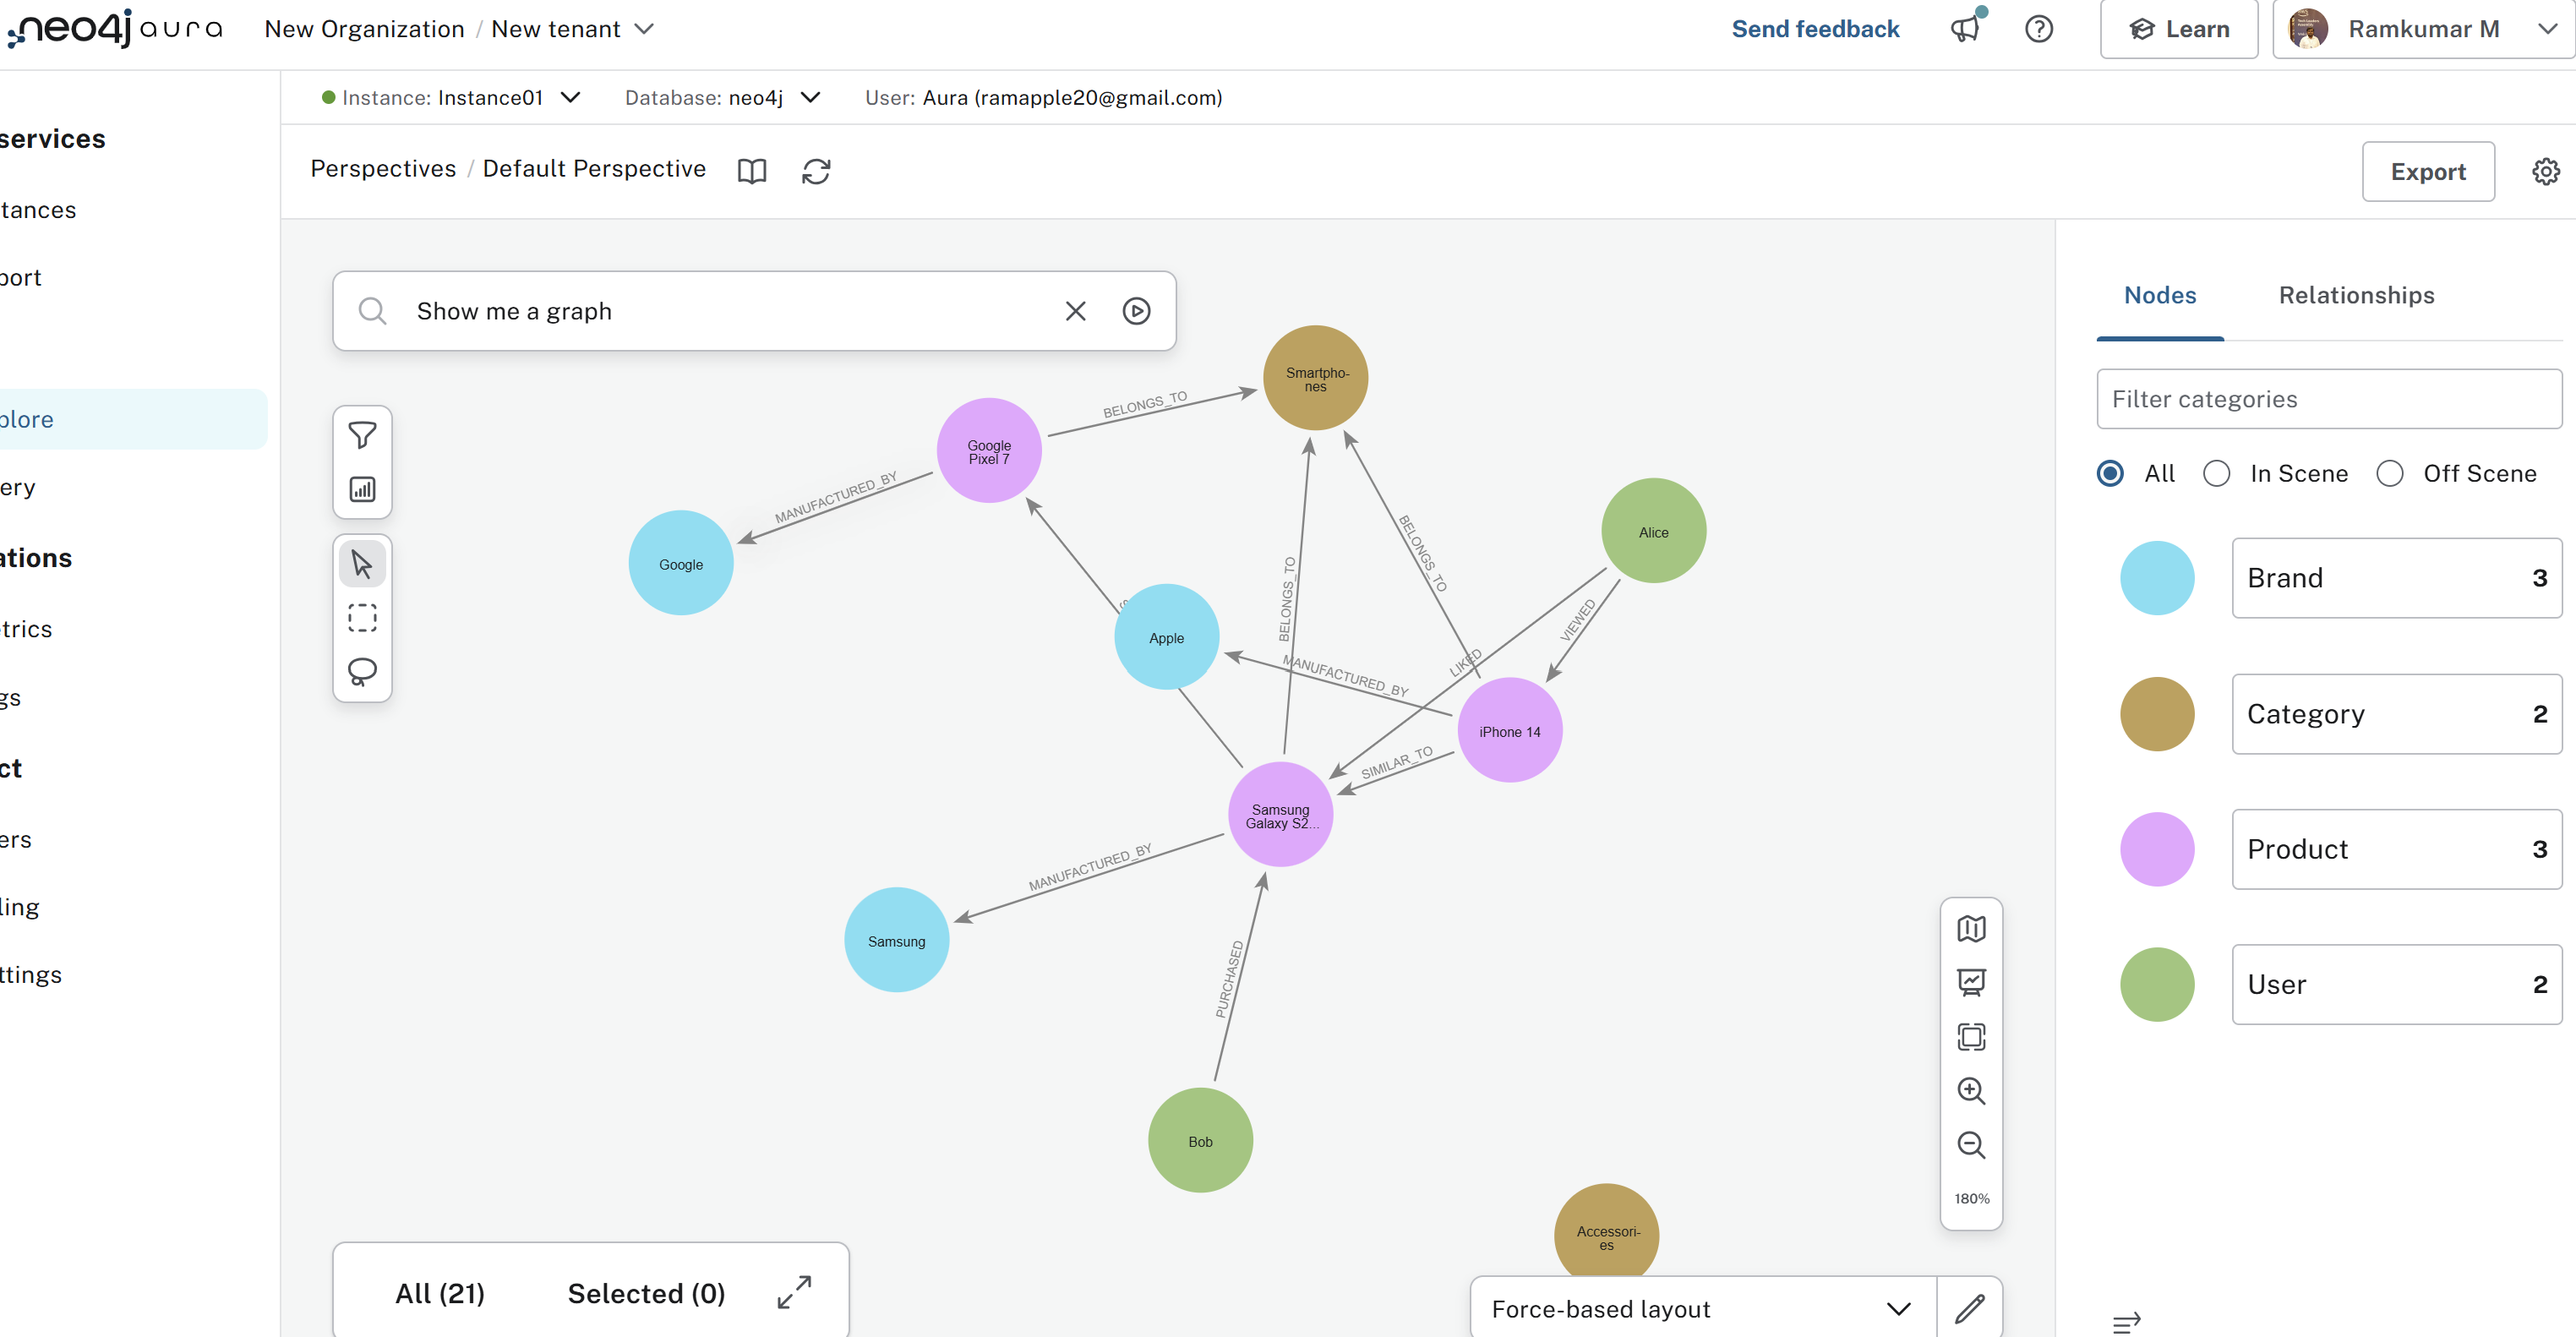

In [46]:
from IPython.display import Image, display


image_path = r"neo4j_updated.png"

# Display the image in Jupyter notebook
display(Image(filename=image_path))


### Stage 2: Querying the Knowledge Graph using GPT-4 for Context-Aware Recommendations

In [38]:
from openai import OpenAI

apikey = "Place your api key here"
# Initialize the OpenAI client with your API key
client = OpenAI(api_key= apikey)  

# Function to generate Cypher query using GPT-4 Chat API
def generate_cypher_query(user_input):
    messages = [
        {"role": "system", "content": "You are a Cypher expert with access to a Neo4j knowledge graph."},
        {"role": "user", "content": f"Translate the following user request into a Cypher query: {user_input}"}
    ]
    
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        max_tokens=100,
        temperature=0.5
    )
    
    # Access the content directly from the message object
    cypher_query = response.choices[0].message.content.strip()
    return cypher_query

# Example user input
user_input = "What products similar to iPhone 14 should I consider?"

# Generate Cypher query using GPT-4
cypher_query = generate_cypher_query(user_input)
print(f"Generated Cypher Query: {cypher_query}")


Generated Cypher Query: Assuming that the graph database is designed in such a way that it contains 'Product' nodes with 'name' property and there is a relationship 'SIMILAR_TO' between similar products, the Cypher query could be something like:

```cypher
MATCH (p:Product {name: 'iPhone 14'})-[:SIMILAR_TO]->(similarProduct:Product)
RETURN similarProduct.name AS Similar_Products
```

This query will find the 'Product' node with the


### Stage 3: Executing the Cypher Query on the Knowledge Graph

In [40]:
import re

# Function to extract the Cypher query from the GPT-4 response
def extract_cypher_query(response_text):
    
    cypher_match = re.search(r'```cypher\n(.*?)\n```', response_text, re.DOTALL)
    
    if cypher_match:
        return cypher_match.group(1).strip()
    else:
        raise ValueError("No valid Cypher query found in the response.")

# Extract only the Cypher query part
cypher_query = extract_cypher_query(cypher_query)  #

# Function to run the Cypher query on Neo4j
def fetch_recommendations(cypher_query):
    with driver.session() as session:
        result = session.run(cypher_query)
        print(type(result))
        print(result)
        recommendations = [record["Similar_Products"] for record in result]
        return recommendations

# Execute the generated Cypher query
recommendations = fetch_recommendations(cypher_query)


print(f"Recommended products: {recommendations}")


C:\Users\ramda\AppData\Local\Temp\ipykernel_90156\1938042964.py:18: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


<class 'neo4j._sync.work.result.Result'>
Recommended products: ['Samsung Galaxy S22']


### Stage 4: GPT-4 Conversational Output

In [44]:
from openai import OpenAI

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=apikey)  

# Function to generate Cypher query using GPT-4 Chat API
def generate_conversational_response(recommendations):
    recommendations_str = ', '.join(recommendations)
    messages = [
        {"role": "system", "content": "You are a helpful assistant providing product recommendations based on user preferences."},
        {"role": "user", "content": f"Based on the user's preferences, recommend these products in a friendly tone: {recommendations_str}"}
    ]
    
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        max_tokens=100,
        temperature=0.7
    )
    
   
    return response.choices[0].message.content.strip()

conversational_response = generate_conversational_response(recommendations)
print(f"GPT-4 Response: {conversational_response}")


GPT-4 Response: Absolutely! If you're a fan of cutting-edge technology and sleek designs, you'll definitely love the Samsung Galaxy S22. This device comes with all the bells and whistles you could possibly need, from a top-notch camera system to an ultra-fast processor for smooth multitasking. It also boasts a vibrant, high-resolution display that's perfect for streaming your favorite shows or gaming. 

Plus, with its robust battery life, you can enjoy all its features without worrying about constantly recharging. The Samsung


### Full Process Summary:

- Stage 1: Construct the KG using Cypher queries in Neo4j.
- Stage 2: Generate Cypher queries using GPT-4 based on user input.
- Stage 3: Execute these Cypher queries to fetch recommendations from the KG.
- Stage 4: Format the fetched results into a conversational response using GPT-4.